In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [22]:
def download_dataset():
    with zipfile.ZipFile('garbage-classification.zip', 'r') as zip_ref:
        zip_ref.extractall('garbage_classification')

np.random.seed(42)
download_dataset()

### Loop through every image → Read the image → Convert the image into 24 numbers (color features) → Save those 24 numbers + the correct class label (0 to 5) into two big lists (data and labels).

In [24]:
def extract_features(image_path):
    img = plt.imread(image_path)
    if img.ndim == 2:  # Handle grayscale (rare)
        img = np.stack((img,) * 3, axis=-1)
    if img.dtype == np.float32 or img.dtype == np.float64:  # Normalize if float
        img = (img * 255).astype(np.uint8)
    features = []
    for c in range(3):
        hist, _ = np.histogram(img[:, :, c].flatten(), bins=8, range=(0, 256))
        features.extend(hist / np.sum(hist))  # Normalize
    return features

classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
data = []
labels = []

for cls_idx, cls in enumerate(classes):
    folder = f'garbage_classification/{cls}'
    if not os.path.exists(folder):
        print(f"Folder {folder} not found. Ensure dataset is unzipped.")
        break
    for img_file in os.listdir(folder):
        if img_file.endswith('.jpg'):
            path = os.path.join(folder, img_file)
            try:
                features = extract_features(path)
                data.append(features)
                labels.append(cls_idx)  # Numerical labels directly
            except Exception as e:
                print(f"Error loading {path}: {e}")

### Create Dataframe

In [25]:
feature_columns = [f'hist_r_{i}' for i in range(8)] + [f'hist_g_{i}' for i in range(8)] + [f'hist_b_{i}' for i in range(8)]
df = pd.DataFrame(data, columns=feature_columns)
df['label'] = labels

print(f"Dataset shape: {df.shape}")
#print(df)

Dataset shape: (3333, 25)


### Step 3: Data Preparation - Training-Testing Split

In [26]:
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2666, 24), Test shape: (667, 24)


### Data visualization

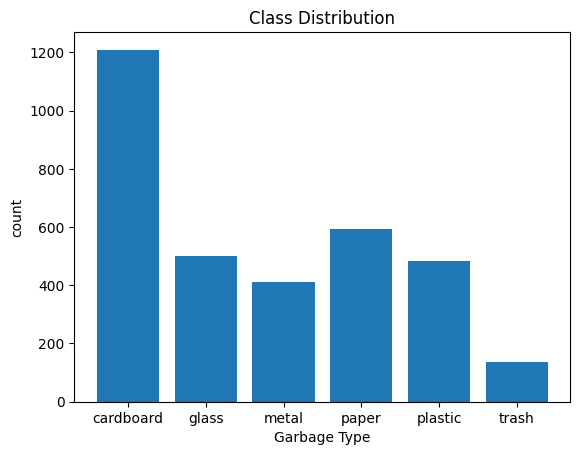

Insights: Class imbalance, e.g., paper has more samples than trash.


In [27]:
# Class distribution bar chart
unique, counts = np.unique(y, return_counts=True)
plt.bar(classes, counts)
plt.title('Class Distribution')
plt.xlabel('Garbage Type')
plt.ylabel('count')
plt.show()
print("Insights: Class imbalance, e.g., paper has more samples than trash.")

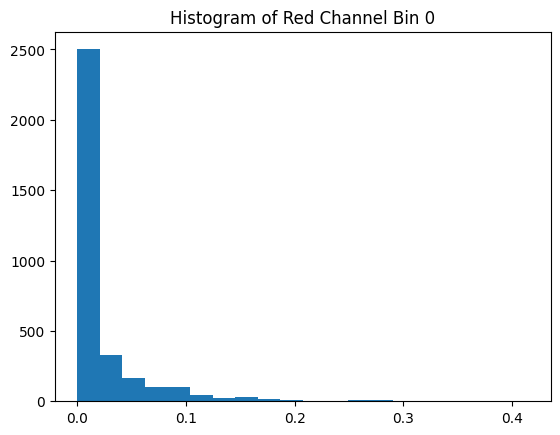

Insights: Shows distribution of low-intensity red pixels across images.


In [28]:
# Histogram of a sample feature
plt.hist(df['hist_r_0'], bins = 20)
plt.title("Histogram of Red Channel Bin 0")
plt.show()
print("Insights: Shows distribution of low-intensity red pixels across images.")

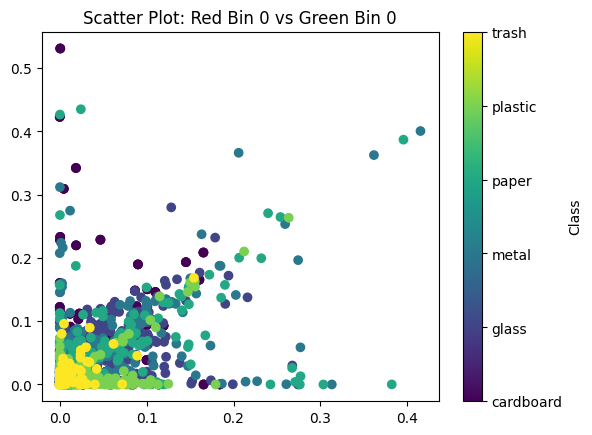

Insights: Some separation by color histograms, -> (glass might have different distributions.)


In [29]:
# Scatter plot of two features colored by class
plt.scatter(X[:, 0], X[:, 8], c=y, cmap='viridis')  # hist_r_0 vs hist_g_0
plt.title('Scatter Plot: Red Bin 0 vs Green Bin 0')
plt.colorbar(ticks=range(len(classes)), label='Class', format=plt.FuncFormatter(lambda x, _: classes[int(x)]))
plt.show()
print("Insights: Some separation by color histograms, -> (glass might have different distributions.)")

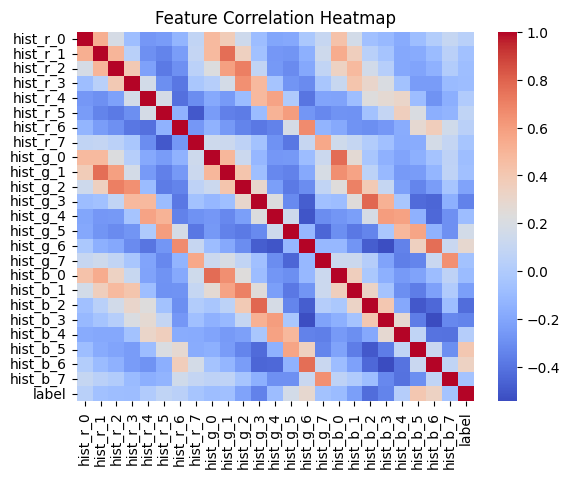

Insights: Identifies correlated histogram bins.


In [30]:
# Correlation Heatmap 
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()
print("Insights: Identifies correlated histogram bins.")

## Model Development

### KNN

In [ ]:
class KNN:
    def __init__(self, k=3):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        preds = []
        for x in X:
            dists = np.linalg.norm(self.X_train - x, axis=1)
            idx = np.argsort(dists)[:self.k]
            votes = self.y_train[idx]
            pred = np.bincount(votes).argmax()
            preds.append(pred)
        return np.array(preds)

# tune k
best_k = 1
best_acc = 0
for k in range(1, 21):
    knn = KNN(k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    acc = np.mean(preds == y_test)
    print(f"K={k}, Accuracy={acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_k = k

print(f"Best K: {best_k} with Accuracy: {best_acc:.4f}")

# Train final KNN with best k
knn = KNN(best_k)
knn.fit(X_train, y_train)

K=1, Accuracy=0.7856
K=2, Accuracy=0.7541
K=3, Accuracy=0.7421
K=4, Accuracy=0.7361
K=5, Accuracy=0.7286
K=6, Accuracy=0.7121
K=7, Accuracy=0.6972
K=8, Accuracy=0.7001
K=9, Accuracy=0.6792
K=10, Accuracy=0.6912
K=11, Accuracy=0.6837
K=12, Accuracy=0.6837
K=13, Accuracy=0.6702
K=14, Accuracy=0.6642
K=15, Accuracy=0.6657
K=16, Accuracy=0.6702
K=17, Accuracy=0.6672
K=18, Accuracy=0.6657
K=19, Accuracy=0.6507
K=20, Accuracy=0.6477
Best K: 1 with Accuracy: 0.7856


### Logistic Regression

In [33]:
class LogisticRegression:
    def __init__(self, lr=0.01, epochs=100):
        self.lr = lr
        self.epochs = epochs
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros(self.n_classes)
        y_onehot = np.eye(self.n_classes)[y]
        
        for epoch in range(self.epochs):
            linear = np.dot(X, self.weights) + self.bias
            probs = self.softmax(linear)
            grad_w = (1 / n_samples) * np.dot(X.T, (probs - y_onehot))
            grad_b = (1 / n_samples) * np.sum(probs - y_onehot, axis=0)
            self.weights -= self.lr * grad_w
            self.bias -= self.lr * grad_b
            # Optional: print loss
            if epoch % 10 == 0:
                loss = -np.mean(np.sum(y_onehot * np.log(probs + 1e-10), axis=1))
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
    
    def predict(self, X):
        linear = np.dot(X, self.weights) + self.bias
        return np.argmax(self.softmax(linear), axis=1)

lr_model = LogisticRegression(lr=0.1, epochs=200)  # Tune lr/epochs as needed
lr_model.fit(X_train, y_train)
print("Model Coefficients (Weights):")
print(lr_model.weights)
print("Biases:")
print(lr_model.bias)
print("Cost Function: Cross-entropy loss for multi-class classification, minimized via gradient descent.")


Epoch 0, Loss: 1.7918
Epoch 10, Loss: 1.7228
Epoch 20, Loss: 1.6798
Epoch 30, Loss: 1.6523
Epoch 40, Loss: 1.6333
Epoch 50, Loss: 1.6191
Epoch 60, Loss: 1.6077
Epoch 70, Loss: 1.5978
Epoch 80, Loss: 1.5890
Epoch 90, Loss: 1.5810
Epoch 100, Loss: 1.5736
Epoch 110, Loss: 1.5667
Epoch 120, Loss: 1.5602
Epoch 130, Loss: 1.5541
Epoch 140, Loss: 1.5483
Epoch 150, Loss: 1.5427
Epoch 160, Loss: 1.5374
Epoch 170, Loss: 1.5324
Epoch 180, Loss: 1.5275
Epoch 190, Loss: 1.5229
Model Coefficients (Weights):
[[-0.0331683   0.02222784  0.03605751  0.00219452 -0.00375794 -0.02355363]
 [ 0.01806745 -0.00992911  0.05484964  0.03479314 -0.05268458 -0.04509653]
 [ 0.04670839 -0.03402804  0.06868229  0.01361286 -0.06125405 -0.03372145]
 [ 0.1122299  -0.05032796  0.02121282 -0.01000809 -0.03270689 -0.04039977]
 [ 0.16925338 -0.04901638 -0.09106959 -0.05380212  0.14479178 -0.12015707]
 [ 0.17303641 -0.04991719 -0.12291591  0.01643326  0.16712661 -0.18376318]
 [ 0.13112062  0.1322734  -0.08656297  0.05237069 -

### K-means

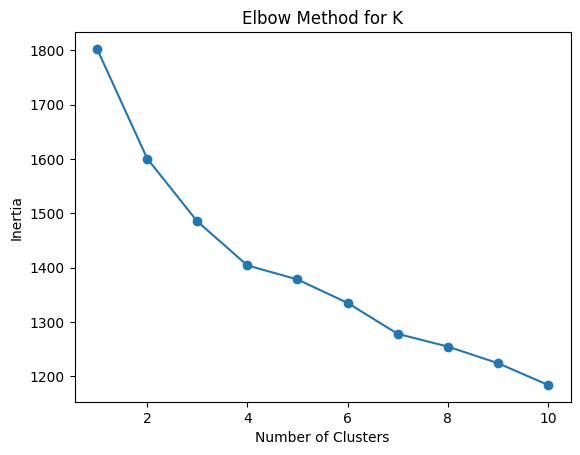

Visualize clusters (using first two features)


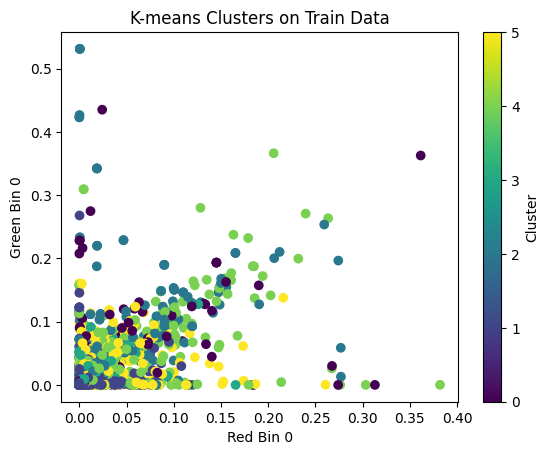

Cluster Interpretation: Groups may correspond to color similarities, e.g., metallic vs organic garbage.


In [34]:
class KMeans:
    def __init__(self, k=3, max_iter=100):
        self.k = k
        self.max_iter = max_iter
    
    def fit(self, X):
        n_samples, _ = X.shape
        self.centroids = X[np.random.choice(n_samples, self.k, replace=False)]
        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else self.centroids[i] for i in range(self.k)])
            if np.allclose(new_centroids, self.centroids):
                break
            self.centroids = new_centroids
        self.labels_ = labels
        return self.labels_
    
    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    

# Determine number of clusters (elbow method on full X for simplicity)
inertias = []
for k in range(1, 11):
    kmeans = KMeans(k)
    kmeans.fit(X)
    inertia = np.sum(np.min(np.linalg.norm(X[:, np.newaxis] - kmeans.centroids, axis=2), axis=1))
    inertias.append(inertia)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method for K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()
# Assume optimal k=6 (matching classes)
optimal_k = 6
kmeans = KMeans(optimal_k)
cluster_labels = kmeans.fit(X_train)  # Fit on train

print("Visualize clusters (using first two features)")
plt.scatter(X_train[:, 0], X_train[:, 8], c=cluster_labels, cmap='viridis')
plt.title('K-means Clusters on Train Data')
plt.xlabel('Red Bin 0')
plt.ylabel('Green Bin 0')
plt.colorbar(label='Cluster')
plt.show()
print("Cluster Interpretation: Groups may correspond to color similarities, e.g., metallic vs organic garbage.")